In [1]:
import csv

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from networkx.algorithms import pagerank
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

## Constants
We have defined `FINAL_DATE` to mark the cutoff date for the entire project, we use this for the filter on the network so any games that were released/created after the cutoff date are not included.

In [2]:
FINAL_DATE = datetime(2023, 1, 1)

## Graph Generation

We have three functions to generate directed graphs using the `networkx` package. At the moment, the function `generate_network_filter` removes entries in the collated related games file where the game has a release date or created date after the cutoff date.

In [4]:
def generate_network_filter(filename: str):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        filter_map = defaultdict(bool)
        for row in csv_reader:
            # Check if the created/release date is after 2023, if it is then we can ignore it in the network.
            release_date = datetime.strptime(row[3], "%Y-%m-%d")
            if row[4] == "None":
                row[4] = "2017-10-22T05:21:29Z" # This is a completely random date before the final date.
            created_date = datetime.strptime(row[4], "%Y-%m-%dT%H:%M:%SZ")

            disallowed_games = ["y65797de"]

            if created_date < FINAL_DATE and release_date < FINAL_DATE and \
                row[0] not in disallowed_games and row[1] not in disallowed_games:
                filter_map[row[0]] = True

    return filter_map

def get_weighted_edges_from_csv(filename, filter=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)

        edges = list()
        for row in csv_reader:
            if filter is None:
                edges.append(tuple([row[0], row[1], int(row[2])]))
                continue
            
            if not filter.get(row[0]) or not filter.get(row[1]):
                continue

            edges.append(tuple([row[0], row[1], int(row[2])]))

    return edges

def generate_graph_from_edges(edges_list):
    directed_graph = nx.DiGraph()
    directed_graph.add_weighted_edges_from(edges_list)
    return directed_graph

## Metric Functions

Here are some functions that I am using to measure the network. Currently, we are measuring betweenness centrality, pagerank popularity, and probably some communities in the future.

In [5]:
def find_top_n_pagerank_nodes(g: nx.Graph, n=1):
    values = pagerank(g)
    values_sorted = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
    return list(values_sorted)[0:n]

def get_graph_order_size(g: nx.Graph):
    return g.order(), g.size()

def find_top_n_betweenness_centrality_nodes(g: nx.Graph, n=10):
    degree_centrality = nx.degree_centrality(g)
    betweenness_centrality = nx.betweenness_centrality(g, normalized=True, endpoints=True)

    degree_centrality_sorted = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
    betweenness_centrality_sorted = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))

    keys_top_degree = list(degree_centrality_sorted)[0:n]
    keys_top_betweenness = list(betweenness_centrality_sorted)[0:n]
    return list(set(keys_top_degree) & set(keys_top_betweenness))

def find_degree_sequence(g: nx.Graph):
    return [g.degree(n) for n in g.nodes]

def find_top_n_highest_out_degree_node(g: nx.Graph, n=10):
    return sorted(g.out_degree(), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_out_degree_with_weight(g: nx.Graph, n=10):
    return sorted(g.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_in_degree_node(g: nx.Graph, n=10):
    return sorted(g.in_degree(), key=itemgetter(1), reverse=True)[:n]

def find_top_n_highest_in_degree_with_weight(g: nx.Graph, n=10):
    return sorted(g.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:n]

def is_graph_weakly_connected(g: nx.Graph):
    return nx.is_weakly_connected(g)

def find_number_weakly_connected_components(g: nx.Graph):
    return nx.number_weakly_connected_components(g)


## Full Games Network

We are generating a network using the entire related games network that has been filtered using the previously mentioned function. This gives us a directed graph with 30,433 nodes**, and **14,739,311 edges**. Without filtering, we get a network that has **30,970 nodes** and **14,857,762 edges**. The filtering removes **537 edges** and **118,451 nodes**.

In [6]:
filter_filename = "../data/games_information/all_games.csv"
graph_filename = "../data/too_big/all_games.csv"
filter_map = generate_network_filter(filter_filename)
edges = get_weighted_edges_from_csv(graph_filename, filter=filter_map)
filtered_graph = generate_graph_from_edges(edges)
print(f"FILTERED: {get_graph_order_size(filtered_graph)}")

edges = get_weighted_edges_from_csv(graph_filename, filter=None)
unfiltered_graph = generate_graph_from_edges(edges)
print(f"UNFILTERED: {get_graph_order_size(unfiltered_graph)}")

FILTERED: (30433, 14739311)
UNFILTERED: (30970, 14857762)


### Metrics of the Full Games Network

We are finding various metrics of the games network. So far, we have found the highest in and out degree nodes, and that the graph is not weakly connected. We will be finding out the betweenness centrality and other metrics.

In [7]:
print(f"HIGHEST OUT: {find_top_n_highest_out_degree_node(filtered_graph)}")
print(f"HIGHEST OUT WITH WEIGHT: {find_top_n_highest_out_degree_with_weight(filtered_graph)}")
print(f"HIGHEST IN: {find_top_n_highest_in_degree_node(filtered_graph)}")
print(f"HIGHEST IN WITH WEIGHT: {find_top_n_highest_in_degree_with_weight(filtered_graph)}")

HIGHEST OUT: [('k6q4rqzd', 9206), ('o1y9j9v6', 7491), ('o1y9wo6q', 7294), ('k6q474zd', 6850), ('om1m3625', 6794), ('46w0n91r', 6683), ('9d3rv59d', 6648), ('3dxz7p1y', 6294), ('pd0wq31e', 6288), ('76rmo418', 6001)]
HIGHEST OUT WITH WEIGHT: [('k6q4rqzd', 151023), ('o1y9wo6q', 101462), ('k6q474zd', 89935), ('o1y9pyk6', 80571), ('o1yj5n21', 79892), ('j1n29w1p', 75175), ('369pxvg1', 72947), ('m1mnnojd', 69459), ('76r55vd8', 69281), ('kdknmqdm', 67686)]
HIGHEST IN: [('k6q4rqzd', 9211), ('o1y9j9v6', 7488), ('o1y9wo6q', 7302), ('k6q474zd', 6855), ('om1m3625', 6795), ('46w0n91r', 6696), ('9d3rv59d', 6656), ('3dxz7p1y', 6299), ('pd0wq31e', 6293), ('76rmo418', 6004)]
HIGHEST IN WITH WEIGHT: [('k6q4rqzd', 2005087), ('j1ne0vl1', 1643535), ('nd285r3d', 1093294), ('w6jl9o5d', 967633), ('3dx2j9y1', 840104), ('j1ll47v1', 758797), ('o1y7pv1q', 553313), ('m1zjnrm6', 551302), ('o1yj5n21', 521378), ('9dowpxm1', 487811)]


The graph is not weakly connected. This means that we cannot reach every node in the graph by moving along edges -- there are some unconnected games.

In [8]:
is_graph_weakly_connected(filtered_graph)

False

In [9]:
find_number_weakly_connected_components(filtered_graph)

38

Here we are analysing the betweenness centrality of the full games network.

In [10]:
def format_games_information_dataframe(df: pd.DataFrame):
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)
    
    # Remove rows with N/As in them.
    df = df.dropna()
    
    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
    
    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') & (df['release_date'] < '2023-01-01')] 
    
    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
    
    # Rename the game_id column to just id.
    df.rename(columns = {'game_id' : 'id'}, inplace=True)

    return df

Below we are doing an inner join on the games information dataframe and the calculated betweenness centrality of the full games network. This gives us all the metadata about the games including their betweenness centrality values. We look for any correlations between the betweenness centrality and the meta data values, but most of them are uncorrelated apart from value vs. num_runs and value vs. num_users. This makes sense as these are *the* two drivers of popularity that we are measuring in our network. More users means more runs, and more runs means more popular. 

In [11]:
games_information_filename = "../data/games_information/all_games.csv"
gi_df = pd.read_csv(games_information_filename)
gi_df = format_games_information_dataframe(gi_df)

betweenness_centrality_filename = "../data/games_network/all_games_betweenness_centrality.csv"
bc_df = pd.read_csv(betweenness_centrality_filename)

merged_df = bc_df.merge(gi_df, on='id', how='inner')

In [12]:
top_n_values = 10
merged_df.sort_values(by="value").tail(top_n_values).iloc[::-1]


,id,value,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
625,o1y9j9v6,0.021817,Celeste,1zk4q26j,2018-01-25,2018-01-15,15,9,32317,5406,14
707,k6q4rqzd,0.021501,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27,29,903,61962,7168,36
441,46w0n91r,0.011311,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30,10,0,15196,3046,20
574,76r55vd8,0.010459,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27,6,0,17212,3790,45
521,nd22xvd0,0.010159,Refunct,ge0ry3ep,2015-10-16,2015-10-20,4,0,5669,1568,6
505,w6jmm26j,0.007873,Cuphead,rzjkx7el,2017-09-29,2017-09-30,19,31,12221,1984,44
727,k6q474zd,0.007672,Minecraft (Classic),None,2009-05-17,2020-09-15,11,0,4563,2599,14
490,268pjodp,0.006675,Barney's Hide & Seek Game,None,1993-06-01,2015-02-08,4,0,365,267,18
4741,j1npme6p,0.006547,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29,15,0,18329,6268,491
432,kdkzrkxd,0.006353,Super Smash Bros. Ultimate,"xv6dvx62,p6xlqm61,5yz8gx6w,4rzj1zlk",2018-12-07,2018-11-26,10,83,5167,853,95


In [13]:
grouped_bc_df = merged_df.groupby(['developers']).sum()
grouped_bc_df.sort_values(by="value").tail(top_n_values).iloc[::-1]

,value,num_categories,num_levels,num_runs,num_users,num_guests
developers,,,,,,
None,1.611427,58893,93559,920020,206470,10462
xv6dvx62,0.056938,601,2193,96465,19022,1227
myzo3pzq,0.039168,826,4075,51862,12431,1737
1zk4q26j,0.022390,32,18,33659,5703,18
"4eppvoer,ne410dem",0.021501,29,903,61962,7168,36
2jevn26k,0.019551,603,485,10450,2540,158
81e7o2z7,0.010574,122,449,10876,1369,49
ge0ry3ep,0.010338,11,8,5759,1595,7
dqe5qkev,0.009625,322,463,4758,942,102


In [14]:
import requests
developer = "xv6dvx62"
response = requests.get(f"https://speedrun.com/api/v1/developers/{developer}")
print(response.json().get("data"))

{'id': 'xv6dvx62', 'name': 'Nintendo', 'links': [{'rel': 'self', 'uri': 'https://www.speedrun.com/api/v1/developers/xv6dvx62'}, {'rel': 'games', 'uri': 'https://www.speedrun.com/api/v1/games?developer=xv6dvx62'}]}


By grouping our dataframe by developer and summing the value column, we get the developers that have the highest betweenness centrality of their games. We find that the top developer is `None`. This means that no developer was listed in the speedrun.com API. The next valid value is `xv6dvx62`, which is Nintendo. Therefore, **Nintendo creates games that are most likely to get people into speedrunning**. In order, the next developers are Capcom, Matt Makes Games Inc., Seterra, Marianne Wartoft, Konami, Vicarious Visions, Dominique Grieshofer, SEGA, StudioMDHR Entertainment Inc.

* [Nintendo](https://nintendo.fandom.com/wiki/List_of_Nintendo_games). Everyone knows Nintendo as it has literally *raised* most adults.
* [Capcom](https://en.wikipedia.org/wiki/List_of_Capcom_games) is previously a titan of arcade games, and owner of franchises such as Street Fighter, Marvel vs. Capcom, Mega Man, Resident Evil, Devil May Cry, Dead Rising, Monster Hunter, Sengoku Basara, Onimusha and Ace Attorney. 
* [Matt Makes Games Inc.](https://www.mattmakesgames.com/) creates games such as Earthblade, Celeste, Towerfall.
* [Marianne Wartoft](https://wartoft.se/) is the creator of Seterra, and created the studio Seterra to continue the development of that website.
* [Konami](https://en.wikipedia.org/wiki/List_of_Konami_games#:~:text=PlayStation%20handhelds%20%20%20%20Title%20%20,July%2018%2C%202019%20%2025%20more%20rows%20) is similar to Capcom. Konami's video game franchises include Metal Gear, Silent Hill, Castlevania, Contra, Frogger, Tokimeki Memorial, Parodius, Gradius, Yu-Gi-Oh!, Suikoden, and eFootball.
* [Vicarious Visions](https://en.wikipedia.org/wiki/Vicarious_Visions) is a game studio that has created a lot of movie tie-in games.
* [Dominique Grieshofer](https://store.steampowered.com/dev/DomGries) has created games such as Refunct and Swarmlake.
* [StudioMDHR Entertainment Inc.](http://studiomdhr.com/about-us/) created Cuphead and the sequel Cuphead: The Delicious Last Course.

<AxesSubplot:>

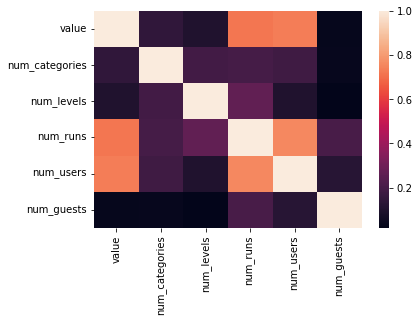

In [15]:
sns.heatmap(merged_df.corr())

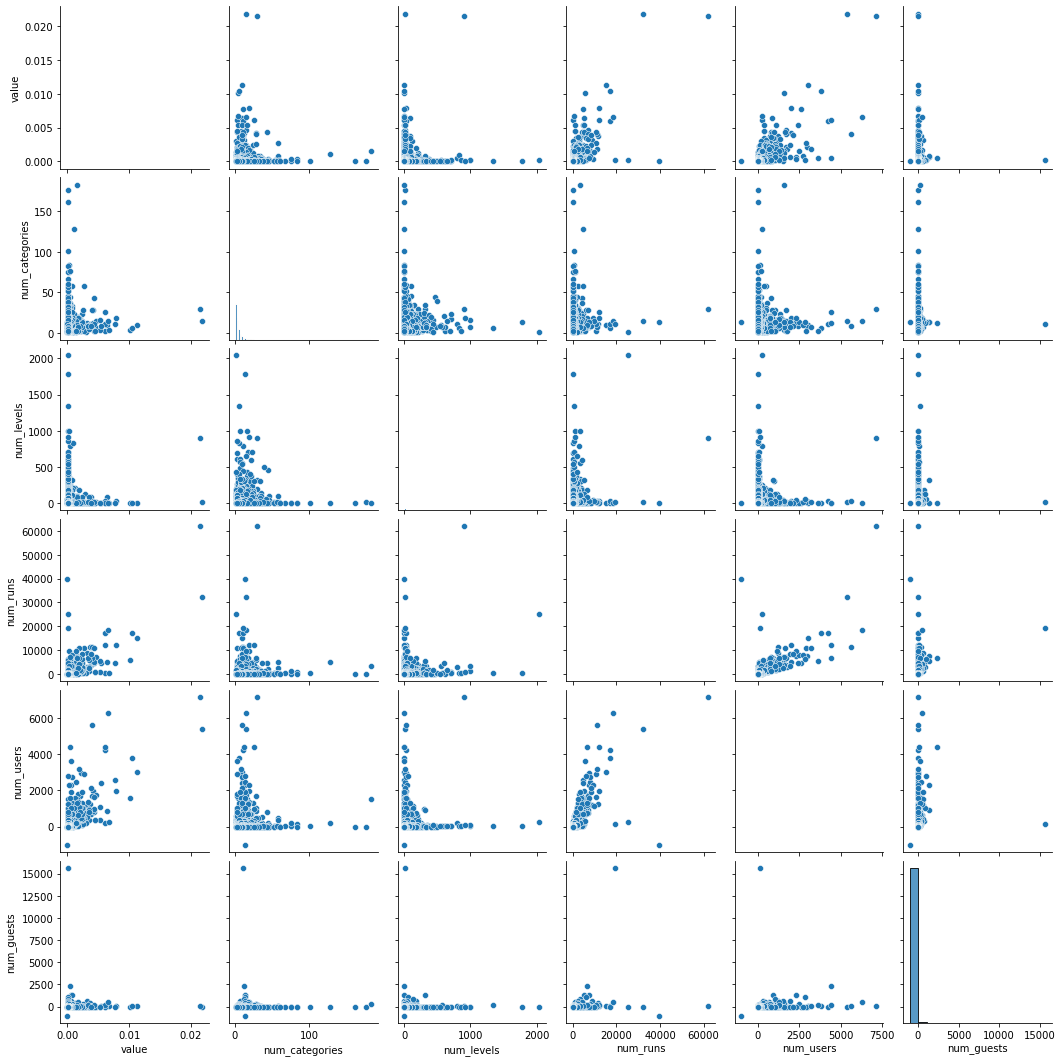

In [16]:
sns.pairplot(merged_df)

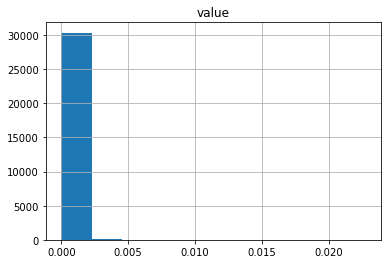

In [17]:
bc_df.hist()
plt.show()

### Visualising the Full Games Network

We are trying two different layouts of visualisation: a circular network for emphasizing nodes, and a spring layout that emphasises the communities.

In [8]:
pos = nx.circular_layout(filtered_graph)
nx.draw_networkx(
    filtered_graph,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)

In [ ]:
pos = nx.spring_layout(filtered_graph, k=0.1)
nx.draw_networkx(
    filtered_graph,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)

### Collaborative Filtering with the Full Games Network

Here we are going to be trying two different kinds of collaborative filtering: item based and user based filtering. 

https://realpython.com/build-recommendation-engine-collaborative-filtering/

https://developers.google.com/machine-learning/recommendation/collaborative/basics

https://medium.com/@urvimidha/recommendation-system-using-collaborative-filtering-in-python-83992251c8f7

In [193]:
user_preference_df = pd.read_csv("../data/collaborative_filtering/user_games_preferences.csv")
user_preference_df.head(10)

,user,games
0,8ewmr728,v1pxk0p6
1,8d4kdg58,"4d79p0r1,4d7np7l6,268wxlo6,j1n8nj91,j1ljjjdg,k..."
2,0jm4ppnj,"pdv223k6,pdvzxkr6,4d7e7z67,9d388w01,9d388kg1,v..."
3,8vk4w7vj,"yd4k8gg6,ldejj3j1,76r3k3q6,m1zjxk36,3698oo3d,k..."
4,zx7q0m08,"j1ngel6p,369vk01l,lden35d3,pd0omwde,j1l2o76g,m..."
5,816mrg5x,"o1y9gqr6,pd0o9wde,v1po5j46,3dx22ny1,j1neljl1,7..."
6,o86lyv58,"w6jkle1j,o1y9nr46,v1pxo5m6,kdkmmg21,4d790zr1,n..."
7,zx7yp6rx,3dx22ny1
8,dx3d1e8l,"v1pk4zd8,nd2ryv60,nd25n3d0,om1m3625,k6qkxz6g,w..."
9,o86qprwx,"4d7954l1,v1plv868,w6jq441j,k6qwwvx6,3698wqgd,4..."


In [199]:
exploded_user_preference_df = user_preference_df.assign(games=user_preference_df['games'].str.split(',')).explode('games')
exploded_user_preference_df = exploded_user_preference_df.reset_index(drop=True)
exploded_user_preference_df = exploded_user_preference_df.drop_duplicates()
exploded_user_preference_df['value'] = 1
exploded_user_preference_df.shape, len(exploded_user_preference_df['games'].unique())

((678112, 3), 32006)

In [ ]:
chunk_size = 10000

# chunk the exploded DataFrame into smaller pieces
chunks = [exploded_user_preference_df[i:i+chunk_size] for i in range(0, exploded_user_preference_df.shape[0], chunk_size)]

# compute the pivot table for each chunk
pivot_tables = []
for chunk in chunks:
    pivot_table = pd.pivot_table(chunk, values='value', index='user', columns='games', fill_value=0)
    pivot_tables.append(pivot_table)

# concatenate the pivot tables into a single DataFrame
exploded_user_preference_df = pd.concat(pivot_tables, axis=1)
exploded_user_preference_df

## Other Percentage Limited Networks 

Using a limited version of the full network (10% representing the collated related games of the first 10% of games in the `data/related_games/` directory, ~3000 games.) we can see how the network evolves over time. We can see that there is a logarithmic increase in the number of nodes, or games, represented in the network when more time progresses.

| Percentage | # Nodes | # Edges |
|----|---|---|
| 10 | 27244 | 1445265 | 
| 20 | 28920 | 2892985 | 
| 30 | 29577 | 4376975 | 
| 40 | 29930 | 5801217 | 
| 50 | 30144 | 8707409 | 
| 60 | 30274 | 9015808 | 
| 70 | 30349 | 10247364 | 
| 80 | 30398 | 11800570 | 
| 90 | 30427 | 13290703 | 

In [6]:
filter_filename = "../data/games_information/all_games.csv"
filter_map = generate_network_filter(filter_filename)

percentages_files = {
    "10":"../data/too_big/all_games_10_percent.csv",
    "20":"../data/too_big/all_games_20_percent.csv",
    "30":"../data/too_big/all_games_30_percent.csv",
    "40":"../data/too_big/all_games_40_percent.csv",
    "50":"../data/too_big/all_games_50_percent.csv",
    "60":"../data/too_big/all_games_60_percent.csv",
    "70":"../data/too_big/all_games_70_percent.csv",
    "80":"../data/too_big/all_games_80_percent.csv",
    "90":"../data/too_big/all_games_90_percent.csv",
}

for percentage, filename in percentages_files.items():
    edges = get_weighted_edges_from_csv(filename, filter=filter_map)
    graph = generate_graph_from_edges(edges)
    print(f"{percentage}: {get_graph_order_size(graph)}")

10: (27244, 1445265)
20: (28920, 2892985)
30: (29577, 4376975)
40: (29930, 5801217)
50: (30144, 7251401)
60: (30274, 8707409)
70: (30349, 10247364)
80: (30398, 11800570)
90: (30427, 13290703)


Getting the top 21 betweenness centrality nodes, which can be seen below.

In [9]:
filter_filename = "../data/games_information/all_games.csv"
graph_filename = "../data/too_big/all_games_10_percent.csv"
filter_map = generate_network_filter(filter_filename)
edges = get_weighted_edges_from_csv(graph_filename, filter=filter_map)
graph = generate_graph_from_edges(edges)
print(get_graph_order_size(graph))

highest_bc_nodes = find_top_n_betweenness_centrality_nodes(graph, n=25)
print(highest_bc_nodes)

(21713, 1798823)
['k6qew96g', 'y65457de', 'm1mp9312', '76rmo418', '4d7eog67', 'w6jkle1j', 'kdkz7ldm', '9doye36p', 'kdkzvmld', '9d3rr0dl', 'kyd4gde4', 'l3dx51yv', 'y658506e', 'v1p0x468', 'm9do0odp', 'pd0wq31e', 'om1m3625', '46w2l76r', 'nd28gvd0', '3dxzqv1y', '369go31l']
